학습 데이터 형태: (9864, 68)
테스트 데이터 형태: (2466, 68)


/opt/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 10/2000
accuracy: 0.9052 - loss: 0.2214 - val_accuracy: 0.9002 - val_loss: 0.2428
Epoch 20/2000
accuracy: 0.9157 - loss: 0.1995 - val_accuracy: 0.9002 - val_loss: 0.2509
Epoch 30/2000
accuracy: 0.9249 - loss: 0.1711 - val_accuracy: 0.8941 - val_loss: 0.2742
Epoch 40/2000
accuracy: 0.9281 - loss: 0.1652 - val_accuracy: 0.8936 - val_loss: 0.2799
Epoch 45: early stopping
Restoring model weights from the end of the best epoch: 15.

최종 테스트 정확도 (Accuracy): 0.8925
최종 테스트 손실값 (Loss): 0.2520
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step

예측값 샘플 (처음 5개):
[[4.9489422e-04]
 [1.9696098e-02]
 [9.8355269e-01]
 [6.9678191e-04]
 [1.8479604e-04]]
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step

[설정된 Threshold]: 0.5
[계산된 F2-Score]: 0.5984

========== [상세 성능 리포트] ==========
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2084
           1       0.68      0.58      0.63       382

    accuracy                           0.89      2466
   macro avg       0.80

/opt/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/ai_basic_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


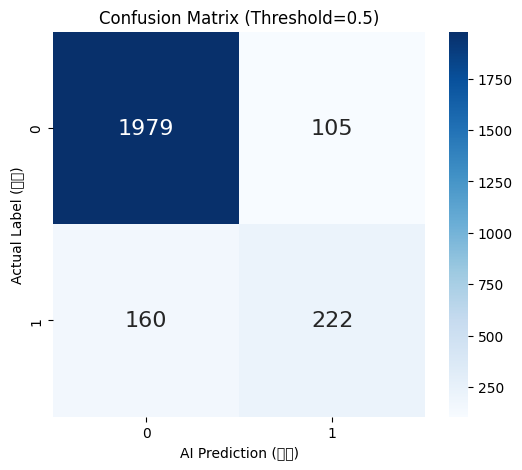

In [8]:
import tensorflow as tf

# GPU가 있어도 안 보이게 설정 (빈 리스트를 줌)
tf.config.set_visible_devices([], 'GPU')

# 이후 코드는 무조건 CPU로 돌아감

from sklearn.metrics import classification_report, confusion_matrix, fbeta_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping

# 커스텀 콜백 정의 (10 에포크마다 출력)
class PrintEpochCallback(Callback):
    def __init__(self, print_every=10):
        self.print_every = print_every

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every == 0:
            print(f"Epoch {epoch + 1}/{self.params['epochs']}")
            print(f"accuracy: {logs['accuracy']:.4f} - loss: {logs['loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f} - val_loss: {logs['val_loss']:.4f}")

# 1. 데이터 불러오기
train = pd.read_csv('../../../data/processed/train.csv')
test = pd.read_csv('../../../data/processed/test.csv')

# 불필요한 식별자 컬럼(row_id) 제거 (데이터에 존재할 경우)
if 'row_id' in train.columns:
    train = train.drop(columns=['row_id'])
if 'row_id' in test.columns:
    test = test.drop(columns=['row_id'])

# 2. 데이터 전처리 (Preprocessing)

# 수치형과 범주형 컬럼 구분
categorical_cols = ['Month', 'VisitorType', 'Weekend', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
numerical_cols = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
                  'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# 숫자 형태의 범주형 데이터(OS, Browser 등)를 문자열로 변환하여 카테고리로 인식하게 함
for col in ['OperatingSystems', 'Browser', 'Region', 'TrafficType']:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

# 원-핫 인코딩 (One-Hot Encoding)
# train과 test의 컬럼을 동일하게 맞추기 위해 합쳐서 인코딩 후 분리
train['is_train'] = 1
test['is_train'] = 0
combined = pd.concat([train, test])

# 범주형 데이터 인코딩
combined = pd.get_dummies(combined, columns=categorical_cols, drop_first=True)

# 다시 Train과 Test로 분리
train_processed = combined[combined['is_train'] == 1].drop(columns=['is_train'])
test_processed = combined[combined['is_train'] == 0].drop(columns=['is_train'])

# Feature(X)와 Target(y) 분리
X_train = train_processed.drop(columns=['Revenue'])
y_train = train_processed['Revenue'].astype(int) # 타겟을 정수형(0,1)으로 변환
X_test = test_processed.drop(columns=['Revenue'])
y_test = test_processed['Revenue'].astype(int)

# 수치형 데이터 스케일링 (StandardScaler)
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# TensorFlow 학습을 위해 float32 타입으로 변환
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

print(f"학습 데이터 형태: {X_train.shape}")
print(f"테스트 데이터 형태: {X_test.shape}")

# 3. 딥러닝 모델 구성 (Build Model)
model = Sequential([
    # 입력층 & 첫 번째 은닉층 (노드 64개)
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2), # 과적합 방지
    
    # 두 번째 은닉층 (노드 32개)
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    # 세 번째 은닉층 (노드 16개)
    Dense(16, activation='relu'),
    
    # 출력층 (이진 분류이므로 노드 1개, 활성화 함수는 sigmoid)
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy', # 이진 분류 손실 함수
              metrics=['accuracy'])

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',         # 검증 손실을 기준으로 모니터링
    patience=30,                # 30 epoch 동안 개선이 없으면 중단
    restore_best_weights=True,  # 가장 좋았던 가중치로 복원
    verbose=1
)

# 4. 모델 학습 (Train)
history = model.fit(X_train, y_train, 
                    epochs=2000,          # 학습 반복 횟수
                    batch_size=32,      # 한 번에 학습할 데이터 크기
                    validation_split=0.2, # 학습 데이터 중 20%를 검증용으로 사용
                    verbose=0,            # 10번당 1번 출력을 위해 기본 출력 끔
                    callbacks=[PrintEpochCallback(print_every=10), early_stopping]) # 콜백 추가

# 5. 성능 평가 (Evaluate)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("\n" + "="*30)
print(f"최종 테스트 정확도 (Accuracy): {accuracy:.4f}")
print(f"최종 테스트 손실값 (Loss): {loss:.4f}")
print("="*30)

# 6. 예측 결과 확인 (Prediction)
# 확률값으로 예측됨 (예: 0.85 -> Revenue가 True일 확률 85%)
predictions = model.predict(X_test)
print("\n예측값 샘플 (처음 5개):")
print(predictions[:5])

# ----------------------------
# 1. 예측값 생성 (Threshold 적용)
# ----------------------------
THRESHOLD = 0.5  # 여기 값을 조절하여 분류 기준 변경 가능 (0.0 ~ 1.0)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > THRESHOLD).astype(int)

# ----------------------------
# 2. 분류 리포트 및 F2-Score
# ----------------------------
# F2 Score: 재현율(Recall)에 2배 가중치 (Recall 중요 시 사용)
f2 = fbeta_score(y_test, y_pred, beta=2)

print(f"\n[설정된 Threshold]: {THRESHOLD}")
print(f"[계산된 F2-Score]: {f2:.4f}")

print("\n========== [상세 성능 리포트] ==========")
print(classification_report(y_test, y_pred))
print("========================================")

# 3. 혼동 행렬 (눈으로 확인하기)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('AI Prediction (예측)')
plt.ylabel('Actual Label (정답)')
plt.title(f'Confusion Matrix (Threshold={THRESHOLD})')
plt.show()

